In [1]:
from modules.models import KdVPinn, create_dense_model
from modules.data import simulate_kdv
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-05-16 16:10:03.940775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
k=6
c=5
phi = 0
def phi_function_PBC(tx,nx=256,nt=201):
    offset =  0
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    u = u.numpy().reshape(nx,-1)
    
    diff = c
    for i in range(1,nt):
        un = u[0:nx-diff-1,i-1].copy() #shifted to right but still in the frame
        u[diff+1:nx,i]= un # shift them to the right for next time frame
        u[0:diff+1,i] = u[-diff-1:nx,i-1] # the remaining first diff points are the old points -10:-1
    u = tf.reshape(tf.convert_to_tensor(u),(-1,1))
    return u


def phi_function(tx):
    offset =  0
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    return u
    

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

# x_start = 0
# length = 8*np.pi
x_start =  -4 #-10
length = 4#10
time =  np.pi/2

In [18]:
nt = 2000
nx = 2000
# int(np.pi*(dt**-1))+1
dx=(length-x_start)/(nx-1)
dt=time/(nt-1)
print(' dx is',dx/dt)



 dx is 5.09295817894065


In [46]:
x_flat = np.linspace(x_start, length, nx)
t_flat = np.linspace(0, time, nt)
x_flat = tf.convert_to_tensor(x_flat)
t_flat = tf.convert_to_tensor(t_flat)
t_, x_ = tf.meshgrid(t_flat, x_flat)
tx_samples = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
# tx = tf.convert_to_tensor(tx)
print(type(t_))
solution = phi_function_PBC(tx_samples,nx,nt)
print(solution.shape)
print(x_flat.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(51456, 1)
(256,)


In [47]:
nx, nt = 256,201
solution = tf.reshape(solution, x_.shape)
print(solution[0,:].shape)

(201,)


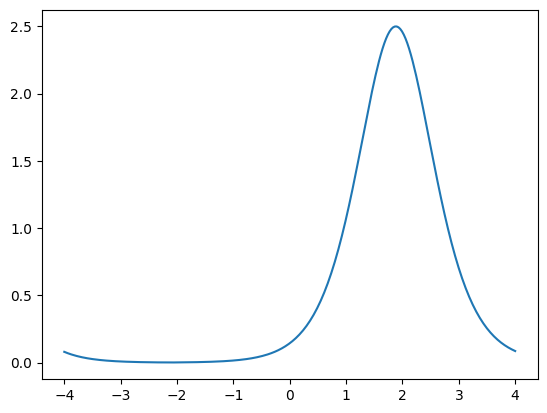

In [49]:
plt.plot(x_flat, solution[:,10])

In [ ]:
u_boundary = tf.reshape(solution[0, :], (-1, 1)) 
boundary_indices = tf.random.shuffle(tf.range(nt, dtype=tf.int32), seed=42)[:nx]
u_boundary = tf.gather(u_boundary, boundary_indices)

In [ ]:
u_boundary.shape
plt.plot(x_flat[:nt],u_boundary,'.')

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( x_start, length))
ax.set_ylim((-0.01, np.sqrt(c)+0.5))

line, = ax.plot([], [], lw=2)
# line2, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    # line2.set_data([], [])
    return (line,)

In [ ]:
def animate(i):
    y=solution[:,i]
#     y2=vfull[:,i*10]
    line.set_data(x_flat,y,)
    
#     line2.set_data(x,y2)
    
    return(line,)

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int((nt-1)), interval=100) #frames is nt

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
f = r"KdVPBC.gif" 
writergif = animation.PillowWriter(fps=10) 
anim.save(f, writer=writergif)

In [3]:
(tx_samples, y_res), (tx_init, u_init), (tx_bnd_start, u_bnd_start_exact), (tx_bnd_end, u_bnd_end_exact) = simulate_kdv(2000, phi_function_PBC, phi_function, x_start, length, time, nx=2000, nt = 2000, random_seed=42, dtype=tf.float32)

2023-05-16 16:10:26.261844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


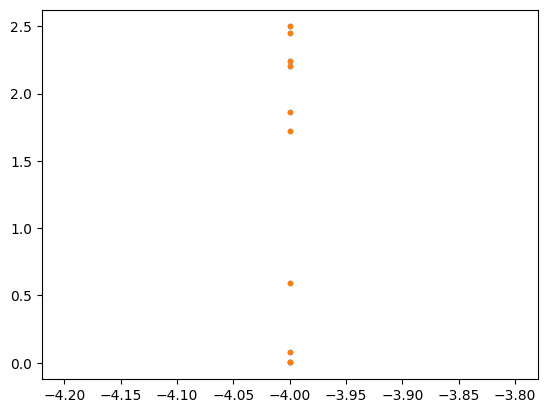

In [7]:
plt.plot( tx_bnd_start[10:20,1:],u_bnd_start_exact[10:20],'.')
plt.plot( tx_bnd_start[10:20,1:],u_bnd_end_exact[10:20],'.')
inputs = [tx_samples, tx_init, tx_bnd_start, tx_bnd_end]
outputs = [phi_function(tx_samples), y_res, u_init, u_bnd_start_exact, u_bnd_end_exact]


In [8]:
backbone = create_dense_model([64, 64, 64], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)

In [15]:
pinn = KdVPinn(backbone, k=k)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.92)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn.compile(optimizer=optimizer)

In [16]:
history = pinn.fit(inputs, outputs, epochs=40000, batch_size=tx_samples.shape[0], verbose=0)

KeyboardInterrupt: 

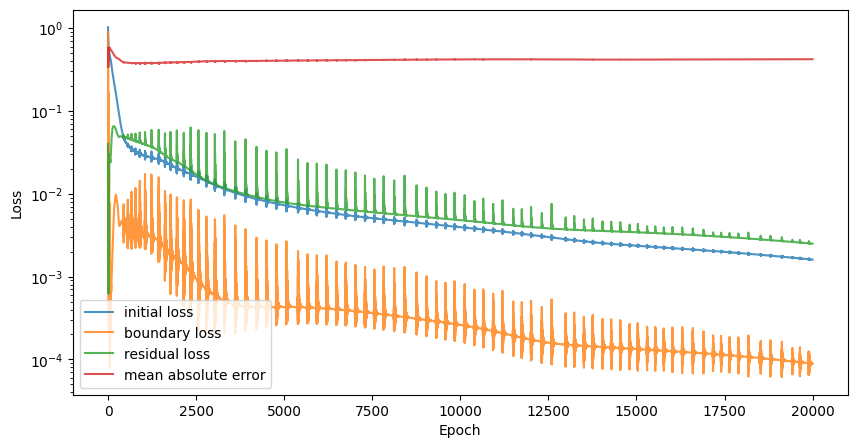

In [17]:
plot_training_loss(history.history, y_scale='log')

1/1 [==============================] - 0s 30ms/step


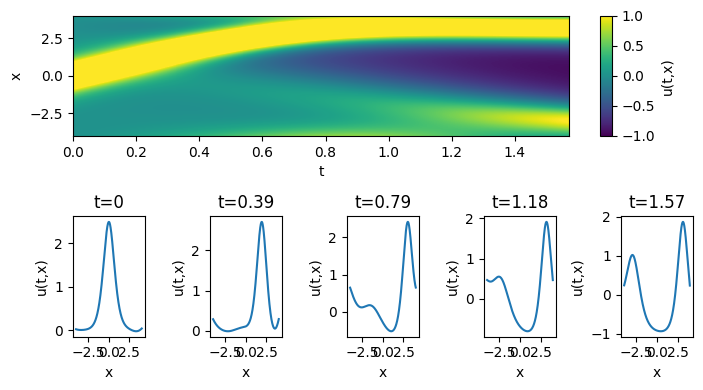

In [18]:
plot_KdV_model(pinn.backbone, x_start,length, time, save_path = None, show=True) 

In [19]:
def plot_snapshots(timeList,num_test_samples = 1000):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    t_flat = tf.convert_to_tensor(t_flat)
    t_, x_ = tf.meshgrid(t_flat, x_flat)
    tx = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
    solution = phi_function_PBC(tx,num_test_samples ,num_test_samples)
    solution = tf.reshape(solution, x_.shape)
    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        print(tx.shape)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction')
        print(int(t_cs/dt+1))
        plt.plot(x_flat, solution[:,int(t_cs/dt)], label = 'exact')
        plt.legend()
        plt.title('t={}'.format(np.round(t_cs,2)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
        return

(1000, 2)
1/1 [==============================] - 0s 103ms/step
764


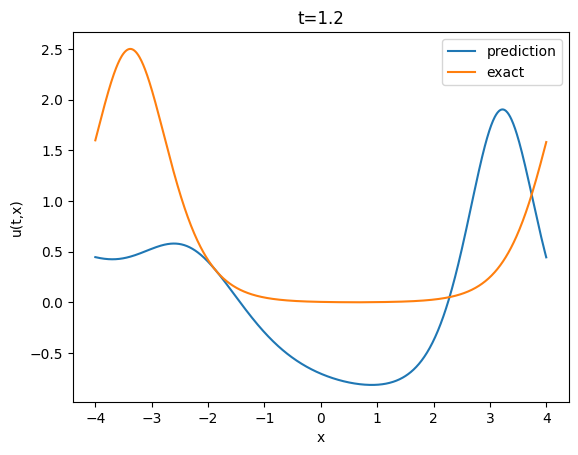

In [20]:
plot_snapshots([1.2])